In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import esda

from libpysal.weights import KNN, lag_spatial
from splot.libpysal import plot_spatial_weights

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationW

In [2]:
KNN_PARAM = 5 # Number of nearest neighbors to create the spatial network
ALPHA_LEVEL = 0.05 # Level for the statistical significance

VARIABLE = 'Indicator24Mean'
VARIABLENAME = 'Alcohol consumption'

NEGATIVE = True
if NEGATIVE:
    pal = 'RdYlGn_r'
else:
    pal = 'RdYlGn'

Read the data

In [3]:
Dat = pd.read_csv("../../../../Data/Processed/DataProvince.csv")

In [4]:
ThailandMap = gpd.read_file("../../../../Data/Enriched/ThailandMapProvinceIdRegion/ThailandMapProvinceIdRegion.shp")
ThailandMap = ThailandMap.rename(columns={'RegionInTh':'RegionInThai'})

ThailandMap['Region'] = ThailandMap['Region'].replace(
    {
        'NorthernThailand': 'Northern Thailand'
        , 'SouthernThailand': 'Southern Thailand'
        , 'WesternThailand': 'Western Thailand'
        , 'EasternThailand': 'Eastern Thailand'
        , 'NortheastThailand': 'Northeast Thailand'
        , 'CentralThailand': 'Central Thailand'
    }
)

ThailandMap = pd.merge(
    ThailandMap
    , Dat[['ProvinceId', VARIABLE]]
    , how='left'
    , on='ProvinceId'
)

ThailandMapWithoutBkk = ThailandMap[ThailandMap['Name']!='Bangkok'].reset_index(drop=True)
ThailandMap = pd.concat([ThailandMapWithoutBkk, ThailandMap[ThailandMap['Name']=='Bangkok']]).reset_index(drop=True)

---

Calculate the spatial weights

In [5]:
WeightKnn = KNN.from_dataframe(ThailandMapWithoutBkk, k=KNN_PARAM)
WeightKnn.transform = 'R'

Calculate the spatial lag

In [6]:
ThailandMapWithoutBkk[VARIABLE + 'SpatialLag'] = lag_spatial(WeightKnn, ThailandMapWithoutBkk[VARIABLE])

ThailandMap = pd.merge(
    ThailandMap
    , ThailandMapWithoutBkk[['ProvinceId', VARIABLE + 'SpatialLag']]
    , how='left'
)

Calculate the global spatial autocorrelation, given by the Moran's I

In [7]:
moran = esda.moran.Moran(ThailandMapWithoutBkk[VARIABLE], WeightKnn)

In [8]:
moran.p_sim

0.001

Calculate the Local Indicator of Spatial Association (LISA), given by the local Moran's I

In [9]:
lisa = esda.moran.Moran_Local(ThailandMapWithoutBkk[VARIABLE ], WeightKnn)

In [10]:
# Find out significant observations
SignificanceLocalMoranI = pd.Series(
    1 * (lisa.p_sim < ALPHA_LEVEL),  # Assign 1 if significant, 0 otherwise
    index=ThailandMapWithoutBkk.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})

In [11]:
ThailandMapWithoutBkk['LocalMoranI'] = lisa.Is
ThailandMapWithoutBkk['SignificanceLocalMoranI'] = SignificanceLocalMoranI

QuadrantDict = {1:'HH', 2:'LH', 3:'LL', 4:'HL'}
ThailandMapWithoutBkk['LisaQuadrant'] = lisa.q
ThailandMapWithoutBkk['LisaQuadrant'] = ThailandMapWithoutBkk['LisaQuadrant'].map(QuadrantDict)

ThailandMapWithoutBkk['MoranCluster'] = ThailandMapWithoutBkk['SignificanceLocalMoranI']
ThailandMapWithoutBkk.loc[ThailandMapWithoutBkk['SignificanceLocalMoranI']=='Significant', 'MoranCluster'] =ThailandMapWithoutBkk.loc[ThailandMapWithoutBkk['SignificanceLocalMoranI']=='Significant', 'LisaQuadrant']

Calculate the variable center and its spatial lag

In [12]:
ThailandMapWithoutBkk['InformalDebtPositiveMeanCenter'] = ThailandMapWithoutBkk[VARIABLE] - ThailandMapWithoutBkk[VARIABLE].mean()
ThailandMapWithoutBkk['InformalDebtPositiveMeanCenterSpatialLag'] = lag_spatial(WeightKnn, ThailandMapWithoutBkk['InformalDebtPositiveMeanCenter'])

In [13]:
ThailandMap = pd.merge(
    ThailandMap
    , ThailandMapWithoutBkk[['ProvinceId', 'InformalDebtPositiveMeanCenter', 'InformalDebtPositiveMeanCenterSpatialLag', 'LocalMoranI', 'SignificanceLocalMoranI', 'LisaQuadrant', 'MoranCluster']]
    , how='left'
)

---

In [14]:
my_colors_quadrant = [
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), # blue
    (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), # light blue
    (1.0, 0.596078431372549, 0.5882352941176471, 1.0), # light red
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0) # red
]

my_colors_significance = [
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), # dark grey
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0) # purple
]

my_colors_quadrant_significance = [
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), # blue
    (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), # light blue
    (1.0, 0.596078431372549, 0.5882352941176471, 1.0), # light red
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), # red
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0) # dark grey
]

Map of the variable, classification, spatial network and spatial lag

/home/dmitri/.local/lib/python3.11/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/dmitri/.local/lib/python3.11/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/tmp/ipykernel_10813/1020422073.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


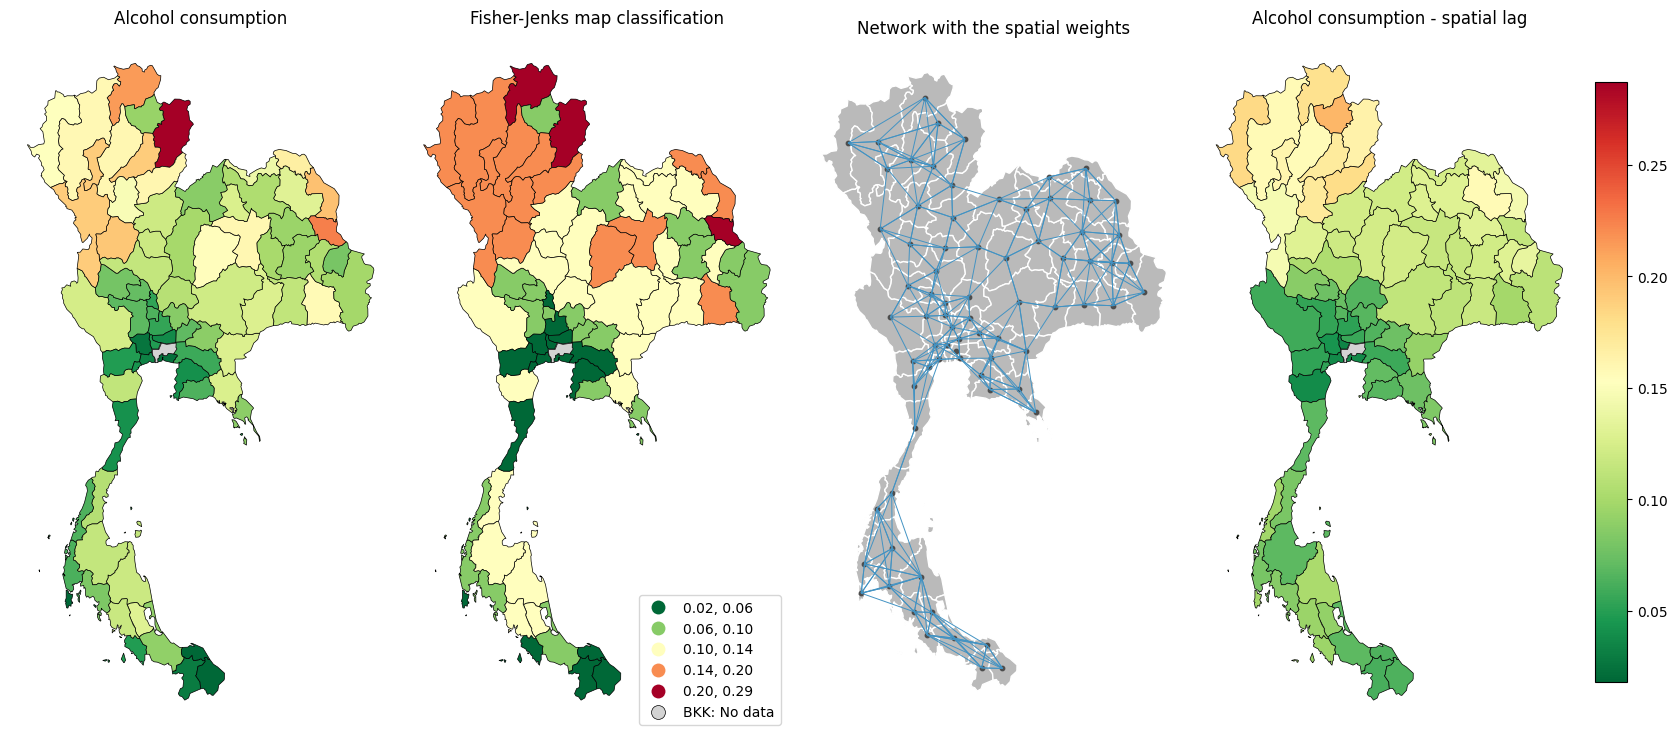

In [15]:
vmin = ThailandMap[[VARIABLE, VARIABLE + 'SpatialLag']].min().min()
vmax = ThailandMap[[VARIABLE, VARIABLE + 'SpatialLag']].max().max()

f, ax = plt.subplots(1, 4, figsize=(16, 7.5), subplot_kw=dict(aspect="equal"))

# Choropleth of variable
ThailandMap.plot(
    VARIABLE 
    , cmap = pal
    , vmin = vmin
    , vmax = vmax
    , ax = ax[0]
    , edgecolor = 'k'
    , linewidth = 0.5
    , missing_kwds = {'color':'lightgrey'}
)
ax[0].set_title(VARIABLENAME)

# Fisher-Jenks map classification
ThailandMap.plot(
    column=VARIABLE,
    scheme="FisherJenks",
    cmap=pal,
    legend=True,
    legend_kwds={"fmt": "{:.2f}", "loc":'lower right'},
    edgecolor='k',
    linewidth=0.5,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'},
    ax=ax[1]
)
ax[1].set_title("Fisher-Jenks map classification")

# Network of spatial weights
plot_spatial_weights(
    WeightKnn,
    ThailandMap,
    figsize=(4,7.5),
    ax=ax[2]
)
ax[2].set_title("Network with the spatial weights")

# Choropleth of spatial lag
ThailandMap.plot(
    VARIABLE + 'SpatialLag'
    , cmap = pal
    , vmin = vmin
    , vmax = vmax
    , ax = ax[3]
    , edgecolor = 'k'
    , linewidth = 0.5
    , missing_kwds = {'color':'lightgrey'}
)
ax[3].set_title(VARIABLENAME + " - spatial lag")

# Remove axis
[ax_.set_axis_off() for ax_ in ax]

# Add the color bar
cbar = plt.cm.ScalarMappable(cmap=pal, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb_ax = f.add_axes([1,0.1,0.02,0.8])
f.colorbar(cbar, cax=cb_ax, orientation="vertical")

# Tight layout to minimize in-between white space
f.tight_layout()

Plot the reference distribution of Moran's I and Moran scatterplot

/tmp/ipykernel_10813/4172612286.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.round(ax[1].get_xticks() + ThailandMapWithoutBkk[VARIABLE].mean(), 2))
/tmp/ipykernel_10813/4172612286.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(np.round(ax[1].get_yticks() + ThailandMapWithoutBkk[VARIABLE].mean(), 2))


[Text(0, -0.1, '0.01'),
 Text(0, -0.07500000000000001, '0.03'),
 Text(0, -0.05, '0.06'),
 Text(0, -0.024999999999999994, '0.08'),
 Text(0, 0.0, '0.11'),
 Text(0, 0.024999999999999994, '0.13'),
 Text(0, 0.05000000000000002, '0.16'),
 Text(0, 0.07500000000000001, '0.18'),
 Text(0, 0.1, '0.21'),
 Text(0, 0.125, '0.23')]

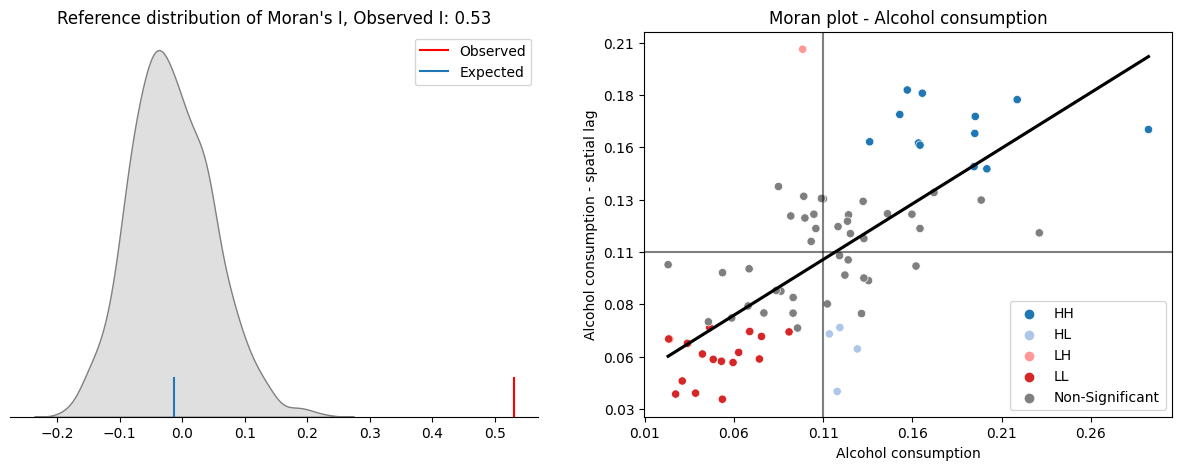

In [16]:
f, ax = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(moran.sim, fill=True, color='grey', ax=ax[0])
ax[0].axvline(x=moran.I, ymax=0.1, c='r', label='Observed')
ax[0].axvline(x=moran.EI, ymax=0.1, label='Expected')

ax[0].set_yticks([])
ax[0].set_ylabel("")
ax[0].set_title("Reference distribution of Moran's I, Observed I: {}".format(round(moran.I,2)))
ax[0].legend()

ax[0].spines[['left', 'right', 'top']].set_visible(False)

sns.scatterplot(
    data=ThailandMapWithoutBkk,
    x="InformalDebtPositiveMeanCenter",
    y="InformalDebtPositiveMeanCenterSpatialLag",
    hue="MoranCluster",
    ax=ax[1],
    hue_order=['HH', 'HL', 'LH', 'LL', 'Non-Significant'],
    palette=sns.color_palette(my_colors_quadrant_significance, as_cmap=True),
)

sns.regplot(
    data=ThailandMapWithoutBkk,
    x="InformalDebtPositiveMeanCenter",
    y="InformalDebtPositiveMeanCenterSpatialLag",
    ci=None,
    scatter=False,
    line_kws={"color": "k"},
    ax=ax[1]
)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles[0:], labels=labels[0:])

ax[1].axvline(0, c="k", alpha=0.5)
ax[1].axhline(0, c="k", alpha=0.5)
ax[1].set_title("Moran plot - " + VARIABLENAME)

ax[1].set_xlabel(VARIABLENAME)
ax[1].set_ylabel(VARIABLENAME + " - spatial lag")

ax[1].set_xticklabels(np.round(ax[1].get_xticks() + ThailandMapWithoutBkk[VARIABLE].mean(), 2))
ax[1].set_yticklabels(np.round(ax[1].get_yticks() + ThailandMapWithoutBkk[VARIABLE].mean(), 2))

Distribution of LISA

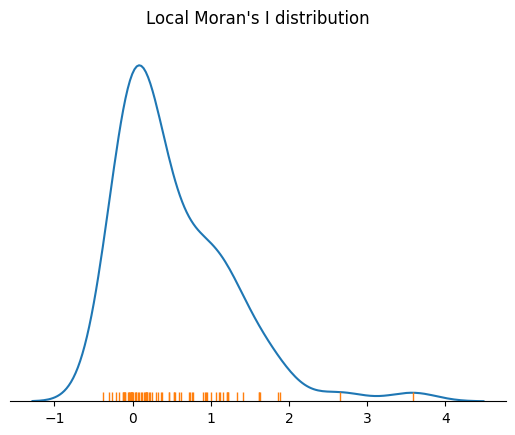

In [17]:
ax = sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is, ax=ax)

plt.yticks([])
plt.title("Local Moran's I distribution")
plt.ylabel("")

ax.spines[['left', 'right', 'top']].set_visible(False)

In [18]:
np.round(np.average(lisa.Is), 2)

0.52

Plot the Moran cluster map

/tmp/ipykernel_10813/1557944096.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


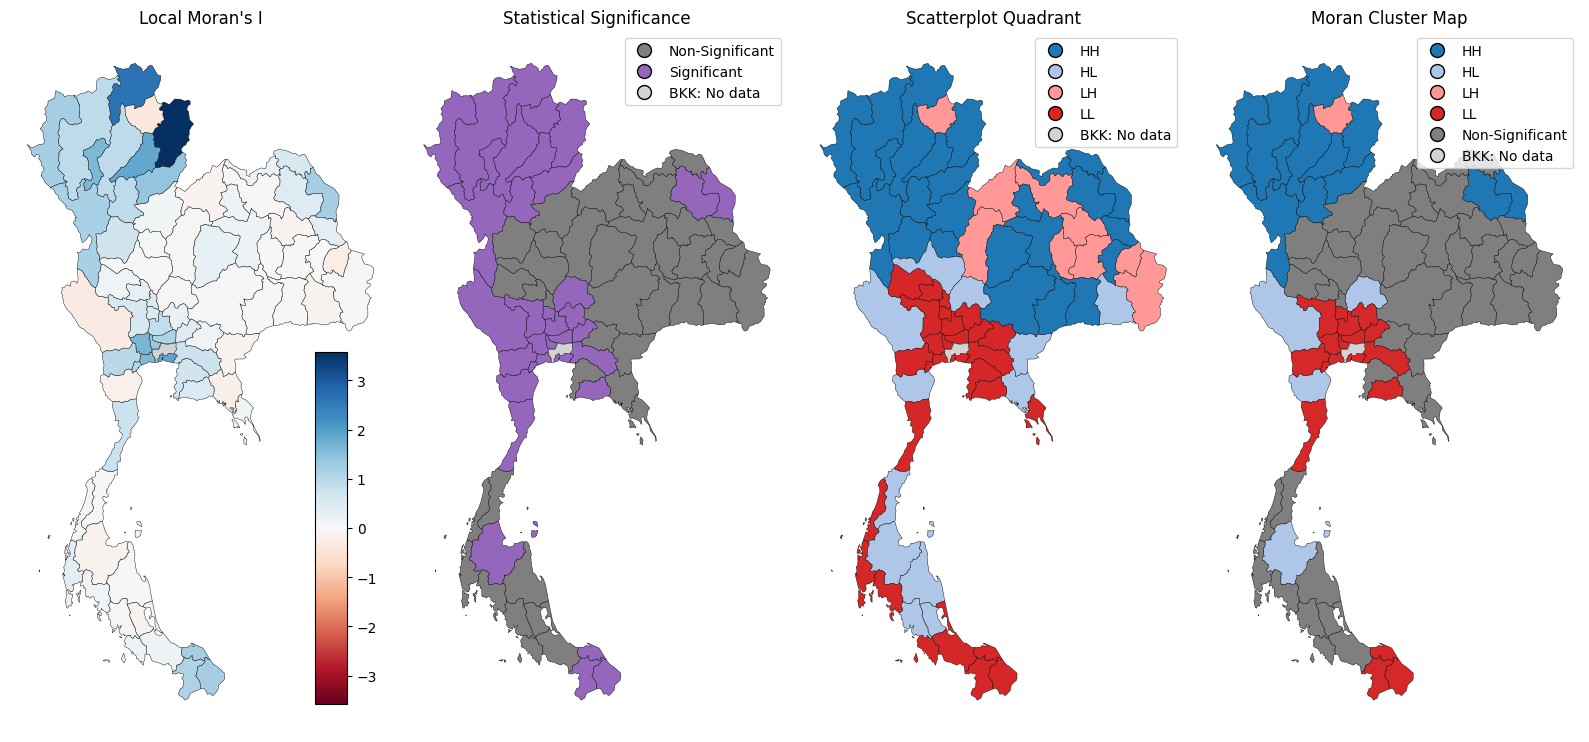

In [19]:
vmax = np.max([np.abs(ThailandMap['LocalMoranI'].min()), np.abs(ThailandMap['LocalMoranI'].max())])
vmin = -vmax

f, axs = plt.subplots(1, 4, figsize=(16, 7.5))

# Choropleth of local statistics
ThailandMap.plot(
    column="LocalMoranI",
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu",
    ax=axs[0],
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Significance map
ThailandMap.plot(
    column="SignificanceLocalMoranI",
    cmap=LinearSegmentedColormap.from_list('my_cmap', colors=my_colors_significance),
    categorical=True,
    legend=True,
    ax=axs[1],
    legend_kwds={"loc":'upper right'},
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Quadrant categories
ThailandMap.plot(
    column="LisaQuadrant",
    cmap=LinearSegmentedColormap.from_list('my_cmap', colors=my_colors_quadrant),
    categorical=True,
    legend=True,
    ax=axs[2],
    legend_kwds={"loc":'upper right'},
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Cluster map
ThailandMap.plot(
    column="MoranCluster",
    cmap=LinearSegmentedColormap.from_list('my_cmap', colors=my_colors_quadrant_significance),
    categorical=True,
    legend=True,
    ax=axs[3],
    legend_kwds={"loc":'upper right'},
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Moran's I",
            "Statistical Significance",
            "Scatterplot Quadrant",
            "Moran Cluster Map",
        ][i],
        y=1,
    )

    if i > 0:
        for legend_handle in ax.get_legend().legend_handles:
                legend_handle.set_markeredgewidth(1)
                legend_handle.set_markeredgecolor('k')

# Add the color bar
cbar = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb_ax = f.add_axes([0.2,0.07,0.02,0.47])
f.colorbar(cbar, cax=cb_ax, orientation="vertical")

# Tight layout to minimize in-between white space
f.tight_layout()

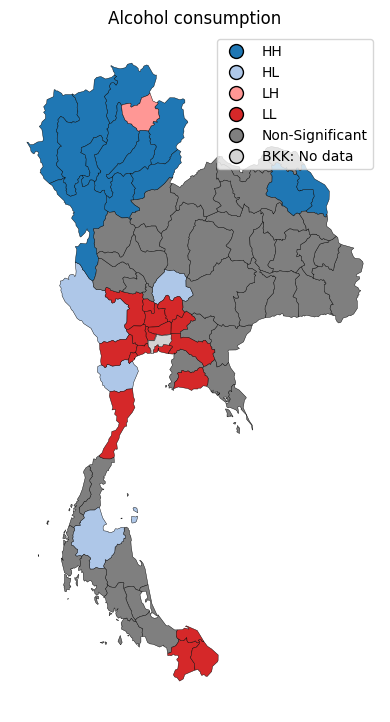

In [20]:
f, ax = plt.subplots(1, 1, figsize=(4, 7.5))

# Cluster map
ThailandMap.plot(
    column="MoranCluster",
    cmap=LinearSegmentedColormap.from_list('my_cmap', colors=my_colors_quadrant_significance),
    categorical=True,
    legend=True,
    ax=ax,
    legend_kwds={"loc":'upper right'},
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Figure styling #
ax.set_title(VARIABLENAME)

for legend_handle in ax.get_legend().legend_handles:
        legend_handle.set_markeredgewidth(1)
        legend_handle.set_markeredgecolor('k')

# Tight layout to minimize in-between white space
f.tight_layout()